In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from model import get_model
from dataset import get_dataset
import tensorflow_probability as tfp
from tqdm.notebook import tqdm
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers import Layer, Conv2D
from sparse_conv2d import SparseConv2D
from utils import expand_layer, propagate_constants

#mixed_precision.set_global_policy("mixed_float16")
from tensorflow.keras.utils import register_keras_serializable

In [2]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
SIZE = 160
base_model, model = get_model(SIZE)
model.load_weights(f"model/model{SIZE}.ckpt")
test_ds, val_ds = get_dataset(False, SIZE, 1, 16, True)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [4]:
def test_propagate(layer):
    in_shape = (1,) + layer.input_shape[1:]
    csts = tf.random.uniform(in_shape, dtype=tf.float16)
    mask = tf.cast(tf.random.uniform(in_shape, minval=0, maxval=1) > 0.8, tf.float16)
    prop = csts * mask
    inputs1 = [tf.random.uniform(in_shape, dtype=tf.float16) for _ in range(10)]
    inputs2 = [inp + prop for inp in inputs1]
    outputs2 = [layer(inp) for inp in inputs2]
    propagate_constants(layer, prop)
    outputs1 = [layer(inp) for inp in inputs1]
    for i,j in zip(outputs1, outputs2):
        print("MEAN DIFF", tf.math.reduce_mean(tf.math.abs(i-j)).numpy())
        print("MEAN OF J", tf.math.reduce_mean(tf.math.abs(j)).numpy())
    print("TEST PASSED?")

In [5]:
biasl = [i for i,l in enumerate(model.layers[1].layers) if (isinstance(l, SparseConv2D) and l.bias is not None)]

In [6]:
test_propagate(model.layers[1].layers[biasl[0]])

MEAN DIFF 0.022561224
MEAN OF J 0.28396082
MEAN DIFF 0.021270666
MEAN OF J 0.18246424
MEAN DIFF 0.022057446
MEAN OF J 0.22380967
MEAN DIFF 0.021929204
MEAN OF J 0.22183421
MEAN DIFF 0.020840928
MEAN OF J 0.16398896
MEAN DIFF 0.021979403
MEAN OF J 0.22189337
MEAN DIFF 0.021397786
MEAN OF J 0.19005106
MEAN DIFF 0.020365866
MEAN OF J 0.15583292
MEAN DIFF 0.021491325
MEAN OF J 0.19949555
MEAN DIFF 0.021112483
MEAN OF J 0.17777877
TEST PASSED?


In [ ]:
for l in base_model.layers:
    if isinstance(l, SparseConv2D):
        expand_layer(l)

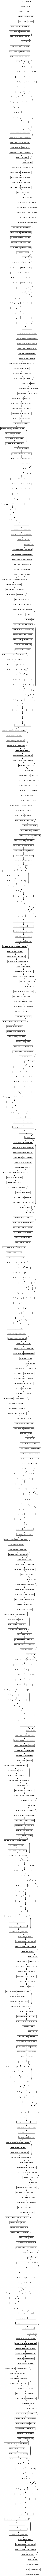

In [11]:
tf.keras.utils.plot_model(base_model)

In [20]:
base_model.layers[3].outbound_nodes[0].outbound_layer

In [5]:
rand = tf.random.uniform(shape=(1, *base_model.input_shape[1:]))

In [5]:
model.save("test.h5")

In [6]:
model = tf.keras.models.load_model("test.h5")

In [1]:
from tensorflow.keras.layers import Layer, Conv2D


class SparseConv2D(Layer):
    def __init__(self, conv_layer=None, in_mask=None, out_mask=None, **kwargs):
        super().__init__(**kwargs)
        self.conv_layer = conv_layer
        self.in_mask = in_mask
        self.out_mask = out_mask

    @classmethod
    def from_config(cls, config):
        conv_layer_config = config.pop("conv_layer")
        conv_layer = Conv2D.from_config(conv_layer_config)
        return cls(conv_layer=conv_layer, **config)

    def build(self, input_shape):
        super().build(input_shape)
        self.conv_layer.build(
            input_shape[:-1]
            + (input_shape[-1] if self.in_mask is None else self.in_mask.shape[-1],)
        )
        self.in_mask = self.conv_layer.add_weight(
            name="in_mask",
            shape=self.conv_layer.input_shape[-1:],
            initializer=tf.keras.initializers.Constant(value=self.in_mask)
            if self.in_mask is not None
            else "ones",
            trainable=False,
        )
        self.out_mask = self.add_weight(
            name="out_mask",
            shape=self.conv_layer.filters,
            initializer=tf.keras.initializers.Constant(value=self.out_mask)
            if self.out_mask is not None
            else "ones",
            trainable=False,
        )

    def call(self, inputs):
        masked_inputs = inputs * self.in_mask
        masked_outputs = self.conv_layer(masked_inputs)
        sparse_outputs = masked_outputs * self.out_mask
        return sparse_outputs

    def compute_output_shape(self, input_shape):
        return self.conv_layer.compute_output_shape(
            input_shape[:-1]
            + (input_shape[-1] if self.in_mask is None else self.in_mask.shape[-1],)
        )

    def get_config(self):
        config = super().get_config()
        config["in_mask"] = (
            self.in_mask.numpy().tolist() if self.in_mask is not None else None
        )
        config["out_mask"] = (
            self.out_mask.numpy().tolist() if self.out_mask is not None else None
        )
        config["conv_layer"] = self.conv_layer.get_config()
        return config

2023-03-13 17:20:15.692292: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 17:20:15.855841: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [27]:
base_model.layers[6].output

<KerasTensor: shape=(None, 80, 80, 24) dtype=float16 (created by layer 'block1a_project_bn')>

In [19]:
base_model.layers[2].get_config()

{'name': 'stem_conv',
 'trainable': False,
 'dtype': {'class_name': 'Policy', 'config': {'name': 'mixed_float16'}},
 'filters': 24,
 'kernel_size': (3, 3),
 'strides': (2, 2),
 'padding': 'same',
 'data_format': 'channels_last',
 'dilation_rate': (1, 1),
 'groups': 1,
 'activation': 'linear',
 'use_bias': False,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'scale': 2.0,
   'mode': 'fan_out',
   'distribution': 'truncated_normal',
   'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Layer


class SparseConv2D(Layer):
    def __init__(self, conv_layer, in_mask=None, out_mask=None):
        super().__init__()
        self.conv_layer = conv_layer
        self.in_mask = in_mask
        self.out_mask = out_mask

    def build(self, input_shape):
        super().build(input_shape)
        self.conv_layer.build(
            in_shape[:-1]
            + (input_shape[-1] if self.in_mask is None else self.in_mask.shape[-1],)
        )
        self.in_mask = self.conv_layer.add_weight(
            name="input_mask",
            shape=self.conv_layer.input_shape[-1:],
            initializer=tf.keras.initializers.Constant(value=self.in_mask)
            if self.in_mask is not None
            else "ones",
            trainable=False,
        )
        self.out_mask = self.add_weight(
            name="output_mask",
            shape=self.conv_layer.filters,
            initializer=tf.keras.initializers.Constant(value=self.out_mask)
            if self.out_mask is not None
            else "ones",
            trainable=False,
        )

    def call(self, inputs):
        masked_inputs = inputs * self.in_mask
        masked_outputs = self.conv_layer(masked_inputs)
        sparse_outputs = masked_outputs * self.out_mask
        return sparse_outputs

    def compute_output_shape(self, input_shape):
        return self.conv_layer.compute_output_shape(
            input_shape[:-1]
            + (input_shape[-1] if self.in_mask is None else self.in_mask.shape[-1],)
        )

In [35]:
l = SparseConv2D(base_model.layers[2])

In [40]:
base_model.layers[2]

In [18]:
insert_layer_nonseq(base_model, 2, ElementWiseMultiply, "pruning", "before")

New layer: pruning Old layer: stem_conv Type: before


ValueError: Exception encountered when calling layer "stem_bn" (type BatchNormalization).

Shape must be rank 4 but is rank 5 for '{{node stem_bn/FusedBatchNormV3}} = FusedBatchNormV3[T=DT_HALF, U=DT_FLOAT, data_format="NHWC", epsilon=0.001, exponential_avg_factor=1, is_training=false](Placeholder, stem_bn/ReadVariableOp, stem_bn/ReadVariableOp_1, stem_bn/FusedBatchNormV3/ReadVariableOp, stem_bn/FusedBatchNormV3/ReadVariableOp_1)' with input shapes: [8,?,80,80,24], [24], [24], [24], [24].

Call arguments received by layer "stem_bn" (type BatchNormalization):
  • inputs=tf.Tensor(shape=(8, None, 80, 80, 24), dtype=float16)
  • training=None

In [16]:
tf.keras.utils.plot_model(base_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [8]:
base_model2 = insert_layer(base_model, 1, ElementWiseMultiply())

AttributeError: The layer "rescaling" has multiple inbound nodes, with different output shapes. Hence the notion of "output shape" is ill-defined for the layer. Use `get_output_shape_at(node_index)` instead.

In [20]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = tf.random.uniform(shape=(1, 28, 28, 1))
model = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)
basic_outs = model(inputs)
model_2 = tf.keras.models.clone_model(model)
model_2.set_weights(model.get_weights())

In [24]:
model_2.layers[1]._input_mask = tf.random.uniform(shape=(1, 28, 28, 1)) > 0.5

In [27]:
model_2.layers[1].get_input_mask_at()

TypeError: Layer.get_input_mask_at() missing 1 required positional argument: 'node_index'

In [4]:
conv_idx = [
    i for i, l in enumerate(base_model.layers) if isinstance(l, tf.keras.layers.Conv2D)
]

In [43]:
[base_model.layers[i].bias is None for i in followed_by_conv2d]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [42]:
followed_by_conv2d = [
    i
    for i in conv_idx
    if type(base_model.layers[i]._outbound_nodes[0].outbound_layer)
    == keras.layers.Multiply
]

In [18]:
is_bias = np.array([base_model.layers[i].use_bias for i in conv_idx])
from utils import get_weights

asort = np.argsort(get_weights(conv_idx, base_model))
is_bias[asort]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [21]:
np.array([base_model.layers[i].strides for i in conv_idx])

array([[2, 2],
       [1, 1],
       [1, 1],
       [2, 2],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [2, 2],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1,

In [5]:
def apply_mask(out, mask, weights):
    # return out * tf.cast(tf.logical_not(mask), tf.float32) + weights * tf.cast(
    #    mask, tf.float32
    # )
    return out * tf.cast(tf.logical_not(mask), tf.float16)

In [6]:
def call_wrapper(func, mask, weights):
    def wrapper(*args, **kwargs):
        return apply_mask(func(*args, **kwargs), mask, weights)

    return wrapper

In [7]:
def set_const(layer, mask, weights):
    if not "partial" in layer.name:
        layer.default_call = layer.call
        layer._name = f"partial_{layer.name}"
    layer._mask = mask
    layer.call = call_wrapper(layer.default_call, layer._mask, weights)

In [8]:
def test():
    weights = tf.random.uniform(shape=[112, 112, 24], minval=0, maxval=4)
    mask = tf.random.uniform(shape=[112, 112, 24], minval=0, maxval=1) > 0.2
    set_const(base_model.layers[conv_idx[0]], mask, weights)
    random_input = tf.random.uniform(shape=[1, 224, 224, 3])
    out1 = base_model.layers[conv_idx[0]].call(random_input)
    out2 = base_model.layers[conv_idx[0]].default_call(random_input)
    print(tf.reduce_sum(tf.cast(out1 == out2, tf.float32) / (112 * 112 * 24)))

In [9]:
def get_activations(model):
    activations = []
    for j, (d, t) in enumerate(test_ds):
        if j == 40:
            break
        activations.append(model(d))
    return tf.concat(activations, 0)

In [ ]:
for i in tqdm(conv_idx):
    m = tf.keras.Model(inputs=base_model.input, outputs=base_model.layers[i].output)
    activations = get_activations(m)
    stds = tf.math.reduce_mean(activations**2, 0)
    means = tf.math.reduce_mean(activations, 0)
    t_min, t_cur, t_max = 0, 50, 100
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
    base_accuracy = model.evaluate(test_ds, verbose=0)[1]
    min_cutoff = 0.0
    print(f"BASELINE: {base_accuracy:.5f}")
    while t_max - t_min > 100 / 2**5:
        cutoff = tfp.stats.percentile(stds, t_cur)
        set_const(base_model.layers[i], stds < cutoff, means)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
        out_accuracy = model.evaluate(test_ds, verbose=0)[1]
        if out_accuracy >= base_accuracy - 1e-3:
            t_min = t_cur
            min_cutoff = cutoff
            if out_accuracy > base_accuracy:
                base_accuracy = out_accuracy
        else:
            t_max = t_cur
        t_cur = (t_max - t_min) / 2 + t_min
        print(f"Accuracy: {out_accuracy:.5f}, threshold: {t_cur}%")
    print(f"Threshold: {min_cutoff:.5f} ({t_min}%)")
    set_const(base_model.layers[i], stds < min_cutoff, means)

  0%|          | 0/140 [00:00<?, ?it/s]

2023-02-15 12:35:04.616971: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401


BASELINE: 0.71240
Accuracy: 0.57120, threshold: 25.0%
Accuracy: 0.70680, threshold: 12.5%
Accuracy: 0.71000, threshold: 6.25%
Accuracy: 0.71240, threshold: 9.375%
Accuracy: 0.71160, threshold: 10.9375%
Threshold: 0.00038 (9.375%)
BASELINE: 0.71160
Accuracy: 0.58000, threshold: 25.0%
Accuracy: 0.67260, threshold: 12.5%
Accuracy: 0.71000, threshold: 6.25%
Accuracy: 0.71100, threshold: 9.375%
Accuracy: 0.70740, threshold: 7.8125%
Threshold: 0.46216 (6.25%)
BASELINE: 0.71100
Accuracy: 0.56160, threshold: 25.0%
Accuracy: 0.65840, threshold: 12.5%
Accuracy: 0.69380, threshold: 6.25%
Accuracy: 0.70300, threshold: 3.125%
Accuracy: 0.70840, threshold: 1.5625%
Threshold: 0.00000 (0%)
BASELINE: 0.71100
Accuracy: 0.65620, threshold: 25.0%
Accuracy: 0.70660, threshold: 12.5%
Accuracy: 0.71120, threshold: 18.75%
Accuracy: 0.71020, threshold: 21.875%
Accuracy: 0.70860, threshold: 20.3125%
Threshold: 7.81250 (18.75%)
BASELINE: 0.71020
Accuracy: 0.59780, threshold: 25.0%
Accuracy: 0.69520, threshold: 1

Accuracy: 0.71200, threshold: 4.6875%
Threshold: 6.71875 (3.125%)
BASELINE: 0.71200
Accuracy: 0.70700, threshold: 25.0%
Accuracy: 0.71240, threshold: 37.5%
Accuracy: 0.70980, threshold: 31.25%
Accuracy: 0.71140, threshold: 28.125%
Accuracy: 0.71240, threshold: 29.6875%
Threshold: 1.17676 (28.125%)
BASELINE: 0.71240
Accuracy: 0.70300, threshold: 25.0%
Accuracy: 0.71020, threshold: 12.5%
Accuracy: 0.71240, threshold: 18.75%
Accuracy: 0.70940, threshold: 15.625%
Accuracy: 0.71040, threshold: 14.0625%
Threshold: 0.00342 (12.5%)
BASELINE: 0.71240
Accuracy: 0.71160, threshold: 75.0%
Accuracy: 0.71020, threshold: 62.5%
Accuracy: 0.71220, threshold: 68.75%
Accuracy: 0.71000, threshold: 65.625%
Accuracy: 0.71220, threshold: 67.1875%
Threshold: 0.06604 (65.625%)
BASELINE: 0.71220
Accuracy: 0.70700, threshold: 25.0%
Accuracy: 0.71020, threshold: 12.5%
Accuracy: 0.71040, threshold: 6.25%
Accuracy: 0.71180, threshold: 9.375%
Accuracy: 0.71200, threshold: 10.9375%
Threshold: 10.35156 (9.375%)
BASELI

In [ ]:
for i in tqdm(conv_idx):
    m = tf.keras.Model(inputs=base_model.input, outputs=base_model.layers[i].output)
    activations = get_activations(m)
    stds = tf.math.reduce_std(activations, 0)
    means = tf.math.reduce_mean(activations, 0)
    t_min, t_cur, t_max = 0, 50, 100
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
    base_accuracy = model.evaluate(test_ds, verbose=0)[1]
    min_cutoff = 0.0
    print(f"BASELINE: {base_accuracy:.5f}")
    while t_max - t_min > 100 / 2**5:
        cutoff = tfp.stats.percentile(stds, t_cur)
        set_const(base_model.layers[i], stds < cutoff, means)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
        out_accuracy = model.evaluate(test_ds, verbose=0)[1]
        if out_accuracy >= base_accuracy - 1e-3:
            t_min = t_cur
            min_cutoff = cutoff
            if out_accuracy > base_accuracy:
                base_accuracy = out_accuracy
        else:
            t_max = t_cur
        t_cur = (t_max - t_min) / 2 + t_min
        print(f"Accuracy: {out_accuracy:.5f}, threshold: {t_cur}%")
    print(f"Threshold: {min_cutoff:.5f} ({t_min}%)")
    set_const(base_model.layers[i], stds < min_cutoff, means)